In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
from tensorflow.python.client import device_lib

for x in device_lib.list_local_devices():
    print(x)

name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4665215628361976762

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 235012096
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15906718299903011359
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"



In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

print('Shape of training set:', mnist.train.images.shape)
print('Shape of training set labels:', mnist.train.labels.shape)
print('Shape of validation set:', mnist.validation.images.shape)
print('Shape of validation set labels:', mnist.validation.labels.shape)
print('Shape of test set:', mnist.test.images.shape)
print('Shape of test set labels:', mnist.test.labels.shape)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Shape of training set: (55000, 784)
Shape of training set labels: (55000, 10)
Shape of validation set: (5000, 784)
Shape of validation set labels: (5000, 10)
Shape of test set: (10000, 784)
Shape of test set labels: (10000, 10)


In [4]:
def create_placeholders(n_h, n_w, n_c, n_y):
    X = tf.placeholder(shape=(None, n_h, n_w, n_c), dtype=tf.float32)
    Y = tf.placeholder(shape=(None, n_y), dtype=tf.int64)
    return (X, Y)

In [5]:
def initialize_parameters(layers):
    l = len(layers)
    parameters = {}
    for i in range(l):
        parameters['W' + str(i + 1)] = tf.get_variable(name='W' + str(i + 1), shape=layers[i], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    return parameters

In [6]:
def forward_propagation(X, parameters):
    A_prev = X
    l = len(parameters)
    for i in range(l):
        Z = tf.nn.conv2d(A_prev, parameters['W' + str(i + 1)], strides=[1, 1, 1, 1], padding='SAME', name='Z' + str(i + 1))
        A = tf.nn.relu(Z, name='A' + str(i + 1))
        P = tf.nn.max_pool(A, ksize=[1, 4, 4, 1], strides=[1, 1, 1, 1], padding='SAME', name='P' + str(i + 1))
        A_prev = P
    P = tf.contrib.layers.flatten(P)
    Z = tf.contrib.layers.fully_connected(P, num_outputs=10, activation_fn=None)
    return Z

In [7]:
def compute_cost(Z, Y):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z, labels=Y))

In [8]:
def cnn(X_train, Y_train, X_valid, Y_valid, X_test, Y_test, layers, learning_rate, num_epochs, minibatch_size=64, print_costs=False):
    tf.reset_default_graph()
    m, n_h, n_w, n_c = X_train.shape
    n_y = Y_train.shape[1]
    X, Y = create_placeholders(n_h, n_w, n_c, n_y)
    parameters = initialize_parameters(layers)
    Z = forward_propagation(X, parameters)
    cost = compute_cost(Z, Y)
    costs = []
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    
    num_minibatches = m // minibatch_size
    
    with tf.Session() as sess:
        sess.run(init)
        initial_time = time.time()
        for num in range(num_epochs):
            permutation = np.random.RandomState(seed=num).permutation(m)
            X_train, Y_train = X_train[permutation, :], Y_train[permutation, :]
            epoch_cost = 0
            for mb in range(num_minibatches):
                _, minibatch_cost = sess.run([optimizer, cost], feed_dict={X: X_train[mb * minibatch_size : (mb + 1) * minibatch_size], Y: Y_train[mb * minibatch_size : (mb + 1) * minibatch_size]})
                epoch_cost += minibatch_cost
            costs.append(epoch_cost / num_minibatches)
            
            if print_costs and num % 10 == 0:
                print('Cost after epoch', num, '=', epoch_cost / num_minibatches)
        
        print('Time taken:', time.time() - initial_time, 'seconds')
        plt.plot(costs)
        plt.xlabel('Epochs')
        plt.ylabel('Cost')
        plt.show()
        par = sess.run(parameters)
        
        correct_predictions = tf.equal(tf.argmax(Y, axis=1), tf.argmax(Z, axis=1))
        accuracy = tf.reduce_mean(tf.cast(correct_predictions, 'float'))
        cummulative_accuracy = 0.0
        batches = m // 50
        for i in range(batches):
            cummulative_accuracy += accuracy.eval({X: X_train[i * 50 : (i + 1) * 50], Y: Y_train[i * 50 : (i + 1) * 50]})
        print('Training Accuracy:', cummulative_accuracy / batches)
        cummulative_accuracy = 0.0
        batches = Y_valid.shape[0] // 50
        for i in range(batches):
            cummulative_accuracy += accuracy.eval({X: X_valid[i * 50 : (i + 1) * 50], Y: Y_valid[i * 50 : (i + 1) * 50]})
        print('Validation Accuracy:', cummulative_accuracy / batches)
        cummulative_accuracy = 0.0
        batches = Y_test.shape[0] // 50
        for i in range(batches):
            cummulative_accuracy += accuracy.eval({X: X_test[i * 50 : (i + 1) * 50], Y: Y_test[i * 50 : (i + 1) * 50]})
        print('Test Accuracy:', cummulative_accuracy / batches)
    
    return par

Cost after epoch 0 = 0.3552634672926385
Cost after epoch 10 = 0.04050184973058583
Cost after epoch 20 = 0.030107468136807695
Cost after epoch 30 = 0.0237725897118978
Cost after epoch 40 = 0.020254375320734302
Cost after epoch 50 = 0.01749273020420848
Cost after epoch 60 = 0.015021866284530977
Cost after epoch 70 = 0.01217675008166406
Time taken: 312.7884006500244 seconds


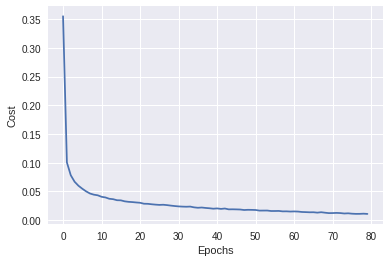

Training Accuracy: 0.9974545475569638
Validation Accuracy: 0.9888000053167343
Test Accuracy: 0.9907000026106835


In [9]:
par = cnn(mnist.train.images.reshape(-1, 28, 28, 1), mnist.train.labels, mnist.validation.images.reshape(-1, 28, 28, 1), mnist.validation.labels, mnist.test.images.reshape(-1, 28, 28, 1), mnist.test.labels, layers=[[6, 6, 1, 10], [4, 4, 10, 5]], num_epochs=80, learning_rate=0.01, print_costs=True)